# Quantum Bloch Solver
***

This notebook is a generalization of the old one-dimensional SU(2) Bloch solver to handle arbitrary symmetry groups, including SO(3). After the 1D version is optimized, I'll add ray-tracing functionality to make the solver 3D.

It'd also be interesting in the future to investigate the full quantum solution.

The main algorithm used in this notebook is the Crank-Nicolson finite difference method combined with the Pade approximant of the Magnus expansion of the usual quantum mechanical propagator.

Approximation chart: PDE -> ODE -> Magnus -> Pade/Crank-Nicolson

    (PDE -> ODE) Semiclassical approximation
    (ODE -> Magnus) Small time step makes the problem quasi-time-independent
    (Magnus -> Pade) Pade approximation gets rid of the matrix exponential
    (Magnus -> Crank-Nicolson) Pade approximation gets rid of the time integral


## Basic constants and functions:
***

In [30]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm,colormaps,colors
import scienceplots
from time import perf_counter
from os import path
from functools import wraps

DEFAULT_FIG_DIRS = {'home':'','laptop':'C:\\Users\\samck\\Documents\\GitHub\\QBS\\figures\\'}
DEFAULT_FIG_DIR = DEFAULT_FIG_DIRS['laptop']
assert path.isdir(DEFAULT_FIG_DIR), 'Figure saving directory not found!'

plt.style.use(['science','notebook', 'grid','default','bright'])
SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 15,18,20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size

sym.init_printing()

def expect(lstate,op,rstate=None,force_real=True):
    '''Returns the expectation value from the given state and operator.'''
    if rstate is None:
        rstate = lstate
    result = np.squeeze((lstate.conj().T)@op@rstate)
    if force_real: result = np.abs(result)
    return result

def get_proj(op,sign=1):
    '''Returns up/down projection operator.'''
    assert sign == -1 or sign == 1, 'The sign must be +/-1.'
    I = np.identity(op.ndim)
    return 1/2*(I + sign*op)

def get_su2_state(theta=0,phi=0,alpha=None,beta=None,gamma=0):
    '''Returns spin state, either with the usual parameterization or two complex numbers.'''
    if alpha is None or beta is None:
        result = [np.cos(theta/2),np.sin(theta/2)*np.exp(1j*phi)]
    else:
        norm = np.sqrt(np.abs(alpha)**2 + np.abs(beta)**2)
        result = 1/norm*[alpha,beta]
    return np.exp(1j*gamma)*np.vstack(result)

def get_so3_state(r=1,theta=0,phi=0,x=None,y=None,z=None):
    '''Returns polarization vector, either using spherical or cartesian coordinates.'''
    if x is None or y is None or z is None:
        x = r*np.cos(phi)*np.sin(theta)
        y = r*np.sin(phi)*np.sin(theta)
        z = r*np.cos(theta)
    return np.vstack((x,y,z))

def get_su2(x=0,y=0,z=0):
    '''Returns arbitrary element of su(2).'''
    r1 = [z,x-1j*y]
    r2 = [x+1j*y,-z]
    return np.vstack((r1,r2))

def get_so3(x=0,y=0,z=0):
    '''Returns arbitrary element of so(3).'''
    r1 = [0,-z,y]
    r2 = [z,0,-x]
    r3 = [-y,x,0]
    return np.vstack((r1,r2,r3))

def cos(x,amp,freq,phase,shim,offset):
    """Returns a cosine with ampitude, frequency, phase, shim, and offset."""
    return amp*np.cos(freq*(x - offset) + phase) + shim

def gauss(x,amp,av,sd,shim):
    """Returns a gaussian with ampitude, average, standard deviation, and shim."""
    return amp*np.exp(-1/2*((x - av)/sd)**2) + shim

def lor(x,amp,av,fwhm,shim):
    """Returns a lorentzian with ampitude, average, fwhm, and shim."""
    return amp/np.pi*(fwhm/2/((x - av)**2 + (fwhm/2)**2)) + shim

def ideal_prob(t,omega,Brf,B0,gamma=GAMMA):
    '''Returns spin flip probability for idealized fields (IU flipper).'''
    rabi = np.sqrt((omega - gamma*B0)**2 + (gamma*Brf/2)**2)
    return ((gamma*Brf/2)/rabi)**2*np.sin(rabi*t/2)**2

def B_step(x,x0,x1,amp=1):
    """Returns two-sided step function. Doesn't include left boundary point."""
    return np.where((x0<x) & (x<=x1),amp,0)

def B_smst(x,x0,x1,amp=1):
    """Returns one-sided smoothed step function. Doesn't include left boundary point."""
    a0 = (x0**3 - 3*x0**2*x1)/(x0 - x1)**3
    a1 = 6*x0*x1/(x0 - x1)**3
    a2 = -3*(x0 + x1)/(x0 - x1)**3
    a3 = 2/(x0 - x1)**3
    return np.where((x0<x) & (x<=x1),amp*(a0 + a1*x + a2*x**2 + a3*x**3),B_step(x,x1,x[-1],amp=amp))

def B_double_smst(x,x0,x1,x2,x3,amp=1):
    '''Returns two-sided smoothed step function.'''
    assert x0 < x1 <= x2 < x3, 'Check step bounds!'
    return B_smst(x,x0,x1,amp=amp) - B_smst(x,x2,x3,amp=amp)

def B_noisy(x,x0,x1,amps=[],freqs=[],phases=[],shims=[]):
    """Field profile with tunable level of noise."""
    assert len(freqs)==len(phases)==len(amps)==len(shims), 'Check noise parameters!'
    noise = np.sum([(a*np.cos(f*x + 0) + s) for a,f,p,s in zip(amps,freqs,phases,shims)],axis=0)
    return np.where((x0<x) & (x<x1),noise,0)

def B_sol(x,x0,x1,radius,amp):
    """Returns analytic finite solenoid envelope."""
    sol = (x - x0)/np.sqrt((x - x0)**2 + radius**2) \
    - (x - x1)/np.sqrt((x - x1)**2 + radius**2)
    return amp*sol/np.max(sol)

def get_3D(fx=[],fy=[],fz=[]):
    '''Returns vector function given the 3 scalar components.'''
    fs = fx,fy,fz
    lens = len(fx),len(fy),len(fz)
    result = [f if len(f)!=0 else np.zeros(np.max(lens)) for f in fs]
    result = [[[result[j][i]] for j in range(3)] for i in range(len(result[0]))]
    return np.array(result)

def get_Bt_com(B_lab,time,delta,vg):
    """Returns the field seen by the moving neutron."""
    return np.array([B_lab[int(vg*t/delta)] for t in time])

SI = {'hbar':1.054571e-34,'gamma':-1.832471e8,'mass':1.674927e-27,'larm':-4.632093e14}
GAMMA = -1.832471*1e-1 #neutron gyromagnetic ratio in nice units (rad per mT us)
LAMS = {'CG4B_LAM':5.5,'HB2D_LAM':4.25,'LARM_LAM':4.}  #neutron wavelengths (AA)

def get_vg(lam):
    '''Returns neutron group velocity (cm/us) given wavelenth (AA).'''
    return 2*np.pi*SI['hbar']/SI['mass']*1e6/lam

sx,sy,sz = get_su2(x=1),get_su2(y=1),get_su2(z=1)
pauli = np.array([sx,sy,sz])
lx,ly,lz = get_so3(x=1),get_so3(y=1),get_so3(z=1)
ang_mom = np.array([lx,ly,lz])

### Plotting functions

In [26]:
empty_plot_parms = {'title':'','xlabel':'','ylabel':'','labels':('','','','','')}
Bt_plot_parms = {'title':'Magnetic field components','xlabel':'Time [us]','ylabel':'Strength [mT]',\
               'labels':('$B_x(t)$','$B_y(t)$','$B_z(t)$','$|B(t)|$')}
Bz_plot_parms = Bt_plot_parms|{'title':'Magnetic field components (lab)','xlabel':'Pos [cm]'}
P_plot_parms = {'title':'Polarization','xlabel':'Time [us]','ylabel':'Pol',\
               'labels':('$P_x(t)$','$P_y(t)$','$P_z(t)$','$|P(t)|$')}

def plot_f(f,t,plots=(True,True,True,False),plot_parms=empty_plot_parms):
    '''Plots the projections of the given function f:R->R^3.'''
    fig = plt.figure(figsize=(10,4.5))
    plt.title(plot_parms['title'])
    for i,plot in enumerate(plots[:3]):
        if plot: plt.plot(t,f[:,i],label=plot_parms['labels'][i],color=f'C{i}',linewidth=3)
    if plots[3]:
        tot = np.sqrt(np.sum([fi**2 for fi in f[:,:,0]],axis=1))
        plt.plot(t,tot,'--',label=plot_parms['labels'][3],color='C3',linewidth=2.5)
    plt.xlabel(plot_parms['xlabel'])
    plt.ylabel(plot_parms['ylabel'])
    plt.grid()
    ax = plt.gca()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def plot_Bloch(states,title=None,gradient=True,elev=30,azim=130,roll=0,goal=[0,0,-1],clrmp='inferno'):
    '''Plots the neutron trajectory on the Bloch sphere.'''
    sphere_points = 500
    theta,phi = np.meshgrid(np.linspace(0,np.pi,sphere_points),\
                            np.linspace(0,2*np.pi,sphere_points))
    X = np.cos(phi)*np.sin(theta)
    Y = np.sin(phi)*np.sin(theta)
    Z = np.cos(theta)

    a,e = azim*np.pi/180 - np.pi,elev*np.pi/180 - np.pi/2
    view_coor = np.array([np.cos(a)*np.sin(e),np.sin(a)*np.sin(e),np.cos(e)])
    alphas = np.where(np.dot(states[:,:,0],view_coor)>=0,1,0.33)  #reduce alpha when behind the Bloch sphere
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111,projection='3d',aspect='equal',elev=elev,azim=azim,roll=roll)
    ax.plot_wireframe(X,Y,Z,rstride=40,cstride=40,color='black',alpha=.2,zorder=10)
    ax.plot_surface(X,Y,Z,color='black',alpha=.05,zorder=5)
    ax.set_xlim(-.6, .6)
    ax.set_ylim(-.6, .6)
    ax.set_zlim(-.6, .6)
    plt.axis('off')
    
    if gradient:
        points = np.transpose(states,axes=(0,2,1))  #making color gradient for trajectory
        segs = np.concatenate([points[:-2],points[1:-1],points[2:]],axis=1)
        seg_num = (segs.shape)[0]

        resampled = colormaps[clrmp].resampled(seg_num)
        new_cm = resampled(np.arange(seg_num))
        new_cm[:,-1] = alphas[0:-2:]  #have to remove the first and last points for smoothing
        new_cm = colors.ListedColormap(new_cm)
        
        lc = Line3DCollection(segs,cmap=new_cm)
        ax.add_collection3d(lc)
        lc.set_linewidth(4)
        lc.set_array(time)
        lc2 = Line3DCollection(segs,cmap=clrmp)  #reset colormap for colarbar
        lc2.set_array(time)
        clb = plt.colorbar(lc2,ax=ax,shrink=.4)
        #clb.ax.set_title('Time [us]',pad=20)  #above colorbar
        clb.ax.set_xlabel('\n Time [us]')  #below colorbar
        terminal_colors = new_cm(0.),new_cm(1.)
    else:
        clr = colors.CSS4_COLORS['blue']
        ax.plot(*[states[:,i,0] for i in range(3)],'-',color=clr,linewidth=4,zorder=100)
        terminal_colors = [clr]*2
    
    ax.scatter(0,0,1,color=terminal_colors[0],edgecolors='black',s=100,zorder=49)
    ax.scatter(*states[-1,:,0],color=terminal_colors[-1],edgecolors='black',s=100,zorder=50)
    ax.scatter(*goal,color='red',edgecolors='black',s=100,zorder=51)
    
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

## Propagator definitions and helper functions
***

In [4]:
def get_mesh(points,i,f):
    '''Used to make both the t and z meshes.'''
    mesh = np.linspace(i,f,points)
    step = abs(mesh[1] - mesh[0])  #time step
    return mesh,step

def prop_su2(theta,n):
    '''Returns the analytical propagator for su(2).'''
    return np.squeeze(np.identity(2)*np.cos(theta) + 1j*np.tensordot(n.T,pauli,axes=1)*np.sin(theta))

def prop_so3(theta,n):
    '''Returns the analytical propagator for so(3).'''
    K = np.tensordot(n.T,ang_mom,axes=1)
    return np.squeeze(np.identity(3) + K*np.sin(theta) + K@K*(1 - np.cos(theta)))

def get_angle_n(FI,eps=1e-9):
    '''Returns the value (angle) and direction (n) of the given field integral.'''
    theta = np.sqrt(np.sum([k**2 for k in FI]))
    if theta <= eps: n = np.vstack((0,0,0))
    else: n = FI/theta
    return theta,n

def get_FI(B,tau,method='linear',gamma=GAMMA):
    '''Returns the full field integral for the given time step.'''
    if method=='linear':
        assert isinstance(tau,(int,float)),'tau must be a number to use the linear method!'
        Ix,Iy,Iz = [b*tau for b in B]
    elif method=='average':
        #need to add assertion here
        Ix,Iy,Iz = [(b[0] + b[1])*tau/2 for b in B]
    elif method=='full_integrate':
        assert len(tau)>1,'tau must be an array to use the full_integrate method!'
        Ix,Iy,Iz = [sc.integrate.trapezoid(b,dx=tau) for b in B]
    else:
        raise Exception(f'Field integral method not found! {method=}') 
    return np.vstack((Ix,Iy,Iz))*gamma

def get_rot_frame(states,time,omega,n=np.array([[0],[0],[1]]),inverse=False):
    '''Returns the trajectory in the rotating frame from the lab frame.'''
    if inverse: omega = -omega
    rot_frame = np.array([prop_so3(omega*t,n) for t in time])
    return np.array([r@s for r,s in zip(rot_frame,states)])

def time_run(func):
    '''Times a simulation run. Can be used with any function.
    use .__wrapped__ to get the untimed version of the function.'''
    @wraps(func)
    def wrapper(*args,**kwargs):
        start = perf_counter()
        result = func(*args,**kwargs)
        end = perf_counter()
        print(f'Time taken: {round(end-start,5)} sec')
        return result
    return wrapper        

@time_run
def do_run(initial_state,B_field,time,tau,method='linear',prop_method=prop_so3):
    '''Finds the final state given the propagator method and magnetic field.'''
    states = [initial_state]
    for i,t in enumerate(time[1:]):
        FI = get_FI(B_field[i],tau,method=method)
        theta,n = get_angle_n(FI)
        state = prop_method(theta,n)@states[-1]
        states.append(state)
    return np.array(states)

def do_simulation(initial_state,run_parms,fields,mesh_parms,lam=4.,\
                  plot_B_parms=Bt_plot_parms|{'plot_z_lab':True,'plot_com':True},\
                  plot_P_parms=P_plot_parms|{'plot_pol':True},\
                  get_sim_time=False):
    '''Wrapper for evaluating the do_run command with some helpful functionality.'''
    vg = get_vg(lam)
    time,tau = get_mesh(mesh_parms['t_n'],mesh_parms['t_0'],mesh_parms['t_f'])
    pos,delta = get_mesh(mesh_parms['z_n'],mesh_parms['z_0'],mesh_parms['z_f'])

    B_z = fields['B_z_lab']
    if plot_B_parms['plot_z_lab']:
        plot_f(B_z,pos,plot_parms=Bz_plot_parms,plots=[True]*4)

    B_tot = fields['B_t_lab'] + get_Bt_com(B_z,time,delta,vg)
    if plot_B_parms['plot_com']:
        plot_f(B_tot,time,plot_parms=plot_B_parms)
    
    if get_sim_time:
        states = do_run(initial_state,B_tot,time,tau,**run_parms)
    else:
        states = do_run(initial_state,B_tot,time,tau,**run_parms).__wrapped__
        
    if plot_P_parms['plot_pol']:
        plot_f(states,time,plot_parms=plot_P_parms)
        print(f'Final state: {np.round(states[-1,:],5)}')
    return states

### Magnetic field profile examples

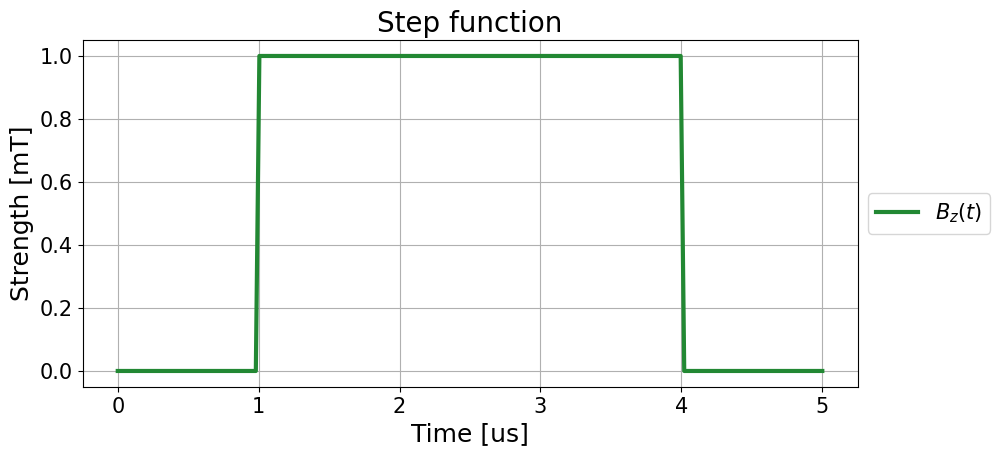

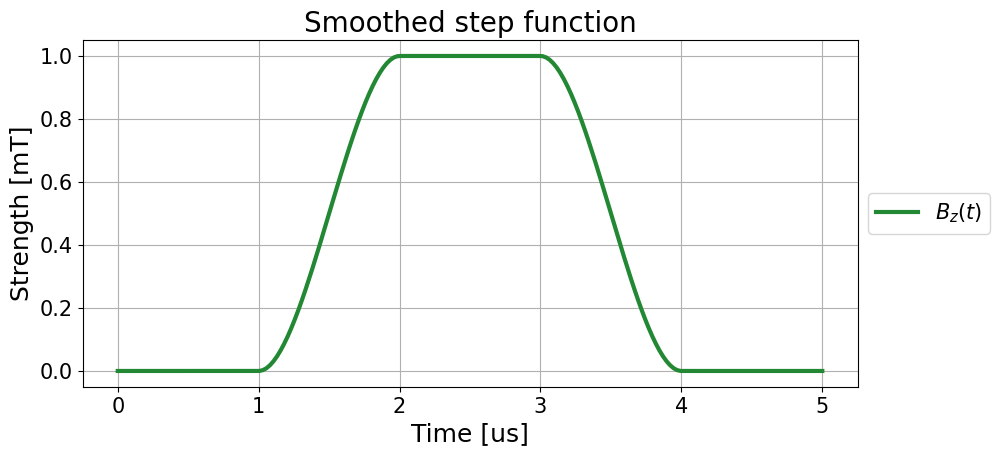

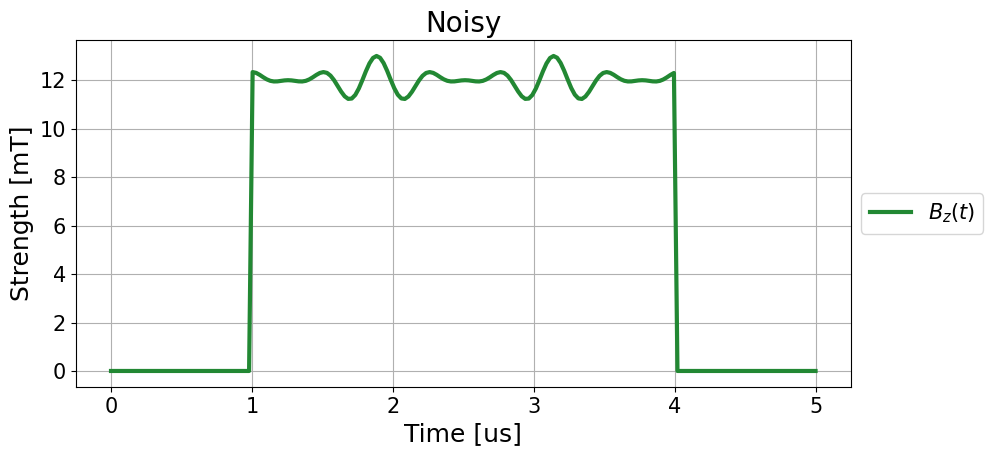

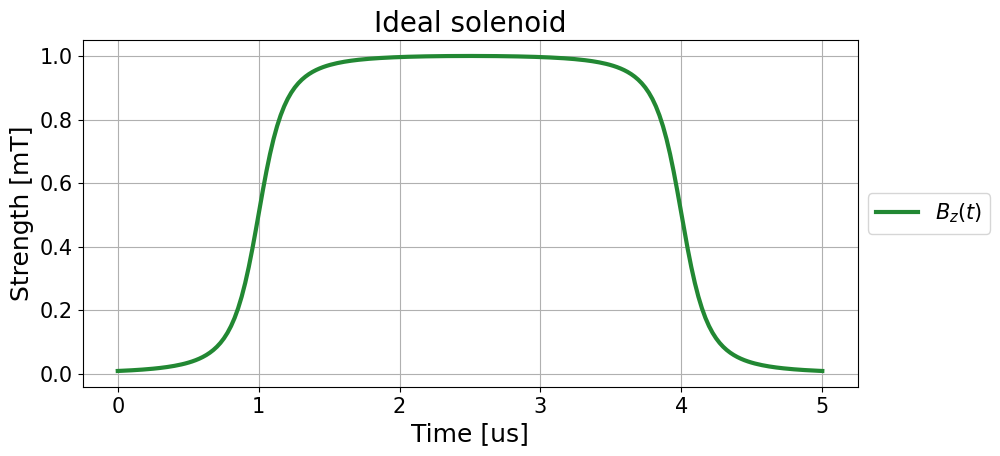

In [32]:
time,tau = get_mesh(200,0,5)
B1 = get_3D(fz=B_step(time,1,4,amp=1))
plot_f(B1,time,plot_parms=Bt_plot_parms|{'title':'Step function'},plots=(0,0,1,0))
B2 = get_3D(fz=B_double_smst(time,1,2,3,4,amp=1))
plot_f(B2,time,plot_parms=Bt_plot_parms|{'title':'Smoothed step function'},plots=(0,0,1,0))
B3 = get_3D(fz=B_noisy(time,1,4,amps=[.2,-.5,.3],freqs=[10,15,20],phases=[0,1,0],shims=[4.,4.,4.]))
plot_f(B3,time,plot_parms=Bt_plot_parms|{'title':'Noisy'},plots=(0,0,1,0))
B4 = get_3D(fz=B_sol(time,1,4,.2,1))
plot_f(B4,time,plot_parms=Bt_plot_parms|{'title':'Ideal solenoid'},plots=(0,0,1,0))

### Propagator tests

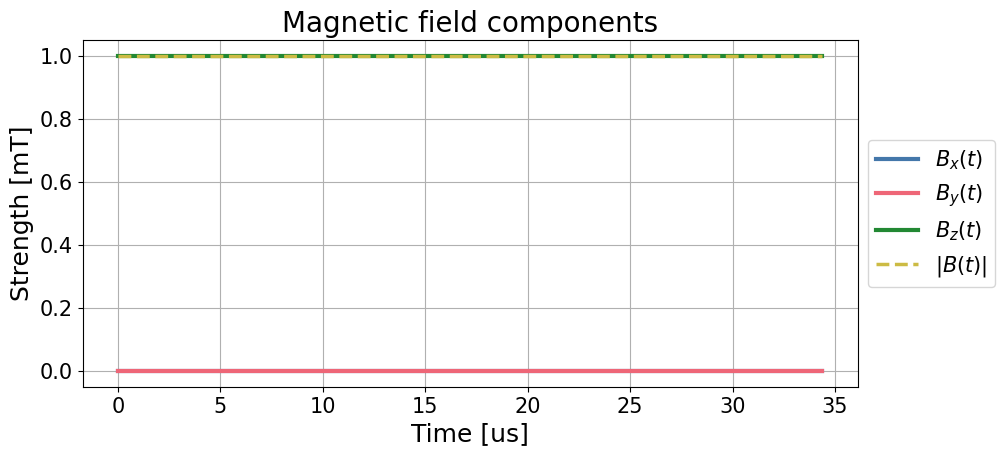

Time taken: 0.0476 sec


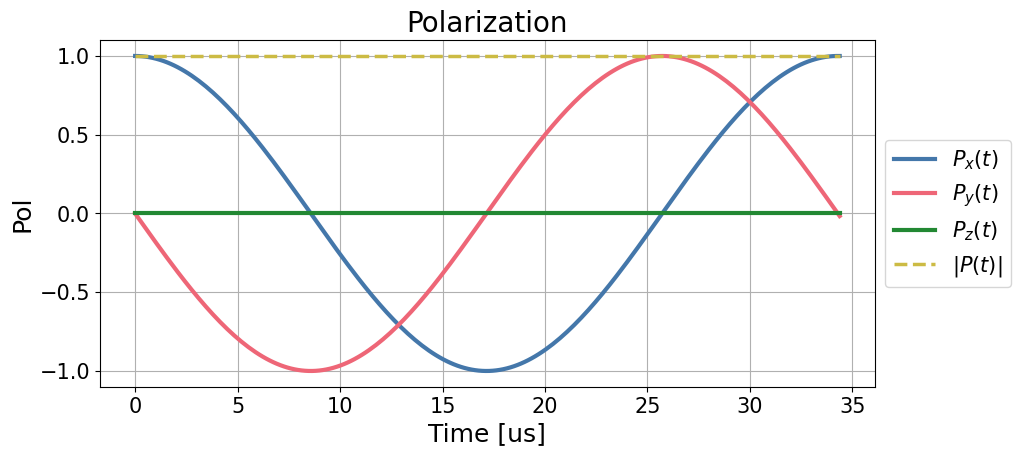

Final state: [[ 0.99986]
 [-0.01646]
 [ 0.     ]]


In [5]:
#constant magnetic field, 34 G cm for 4 Angstrom neutrons should give a 2pi phase shift
t_n = 200  #total number of time points
dist = 3.4  #centimeters
tf = dist/get_vg(4)
time,tau = get_mesh(t_n,0,tf)

B_const = get_3D(fz=np.full(t_n,1))  #10 Gauss field
plot_f(B_const,time,plot_parms=Bt_plot_parms,plots=(True,True,True,True))

start = get_so3_state(x=1,y=0,z=0)
states = do_run(start,B_const,time,tau)
plot_f(states,time,plot_parms=P_plot_parms,plots=(True,True,True,True))
print(f'Final state: {np.round(states[-1,:],5)}')

Time taken: 0.42873 sec
Final state: [[-0.01944]
 [-0.01591]
 [-0.99968]]


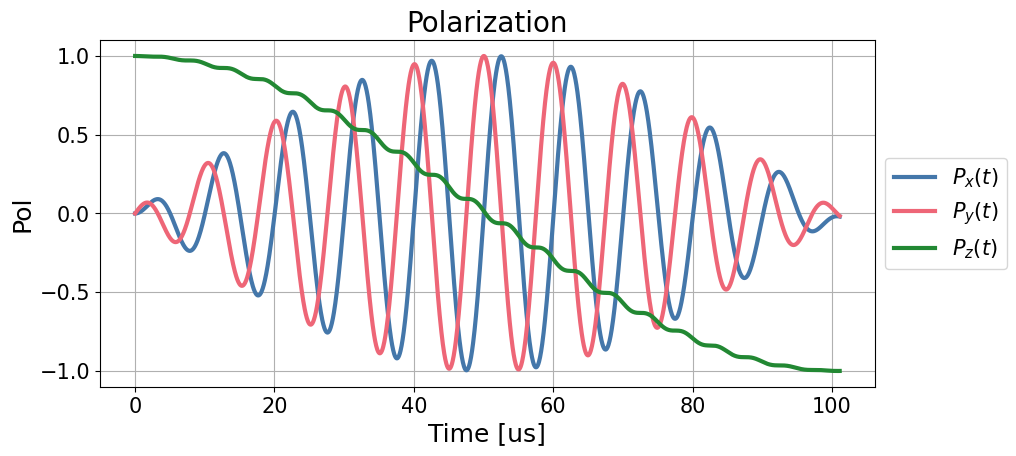

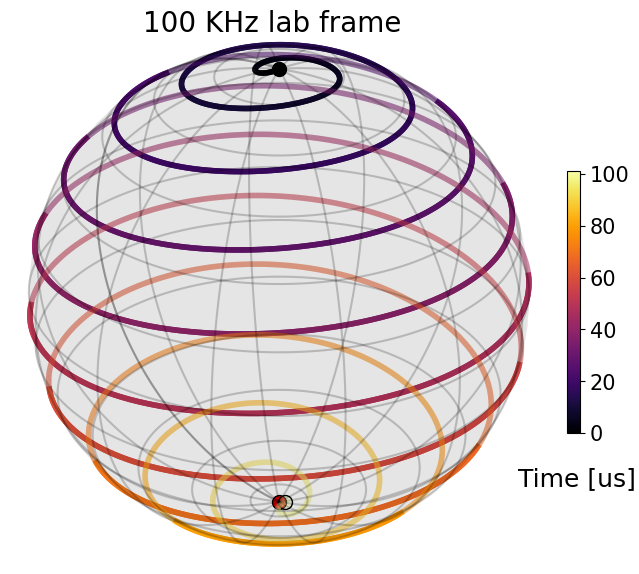

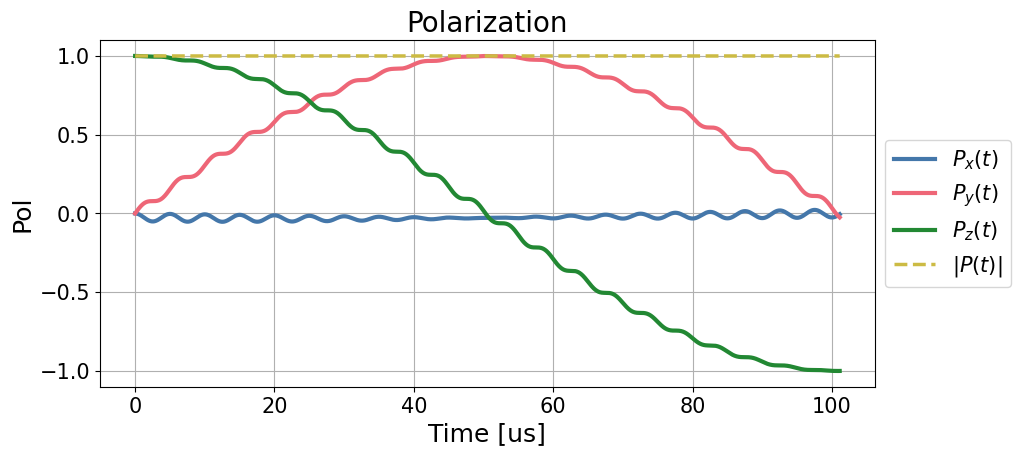

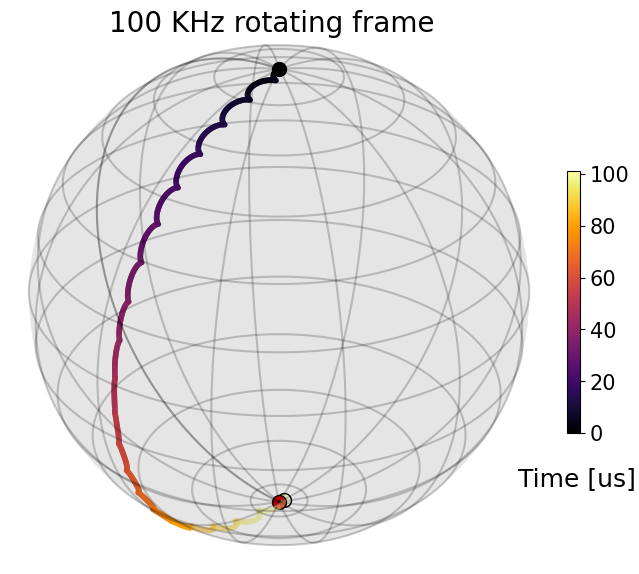

In [20]:
#rf magnetic field at the resonance condition for idealized fields
t_n = 2000  #total number of time points
dist = 10.  #centimeters
tf = dist/get_vg(4)
time,tau = get_mesh(t_n,0,tf)
freq = 100e3*1e-6  #rf frequency (Hz)

B0 = 2*np.pi*freq/abs(GAMMA)
amp = 2*np.pi/abs(GAMMA)/tf

B_rf = get_3D(fz=np.full(t_n,B0),fx=amp*np.cos(2*np.pi*freq*time))
#plot_f(B_rf,time,plot_parms=Bt_plot_parms,plots=(True,False,True,False))

start = get_so3_state(x=0,y=0,z=1)
states = do_run(start,B_rf,time,tau)
print(f'Final state: {np.round(states[-1,:],5)}')

plot_f(states,time,plot_parms=P_plot_parms,plots=(True,True,True,False))
plot_Bloch(states,title=f'{round(freq*1e3)} KHz lab frame',elev=30,azim=130,roll=0,clrmp='inferno')

rotated = get_rot_frame(states,time,2*np.pi*freq)
plot_f(rotated,time,plot_parms=P_plot_parms,plots=(True,True,True,True))
plot_Bloch(rotated,title=f'{round(freq*1e3)} KHz rotating frame',elev=30,azim=130,roll=0,clrmp='inferno')

Amplitude correction factor: 1.27


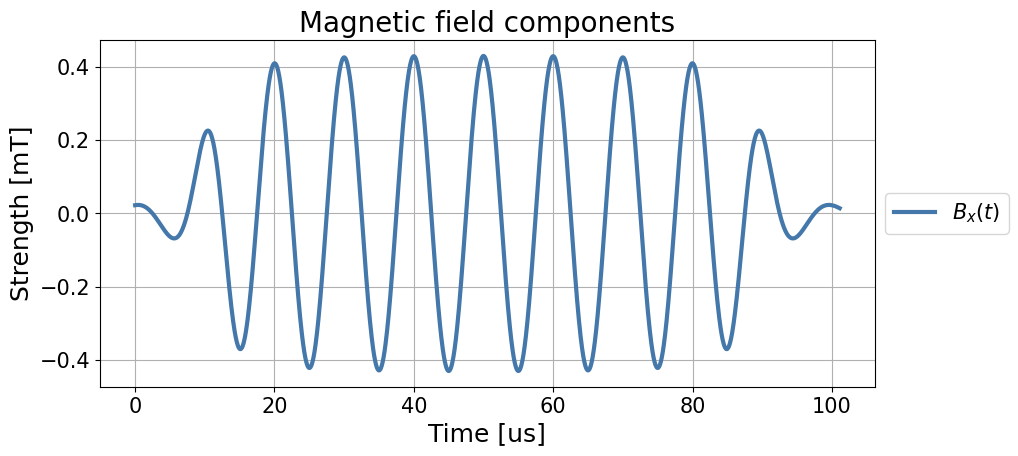

Time taken: 0.22791 sec
Final state: [[ 0.02166]
 [-0.01843]
 [-0.9996 ]]


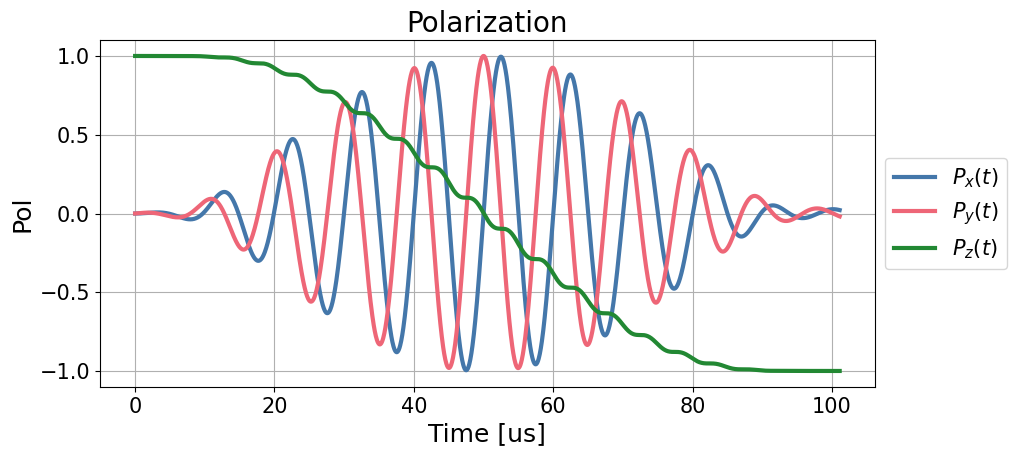

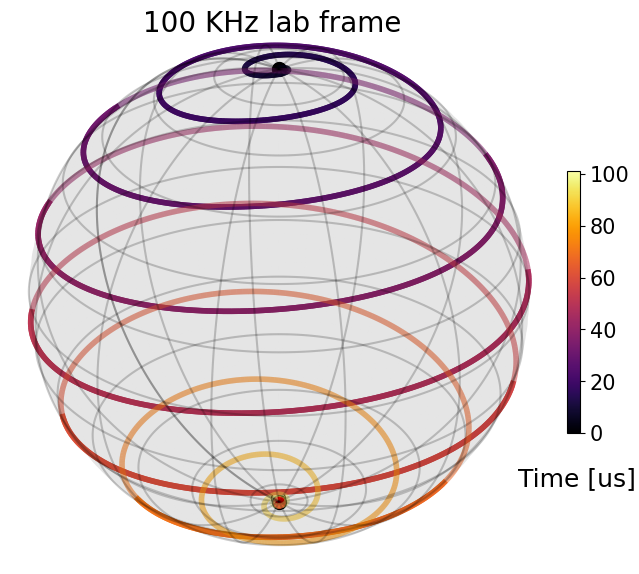

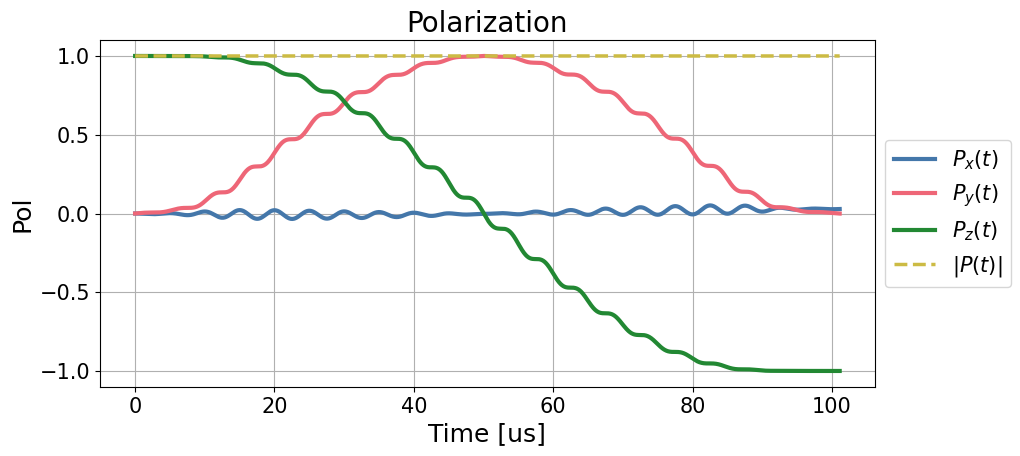

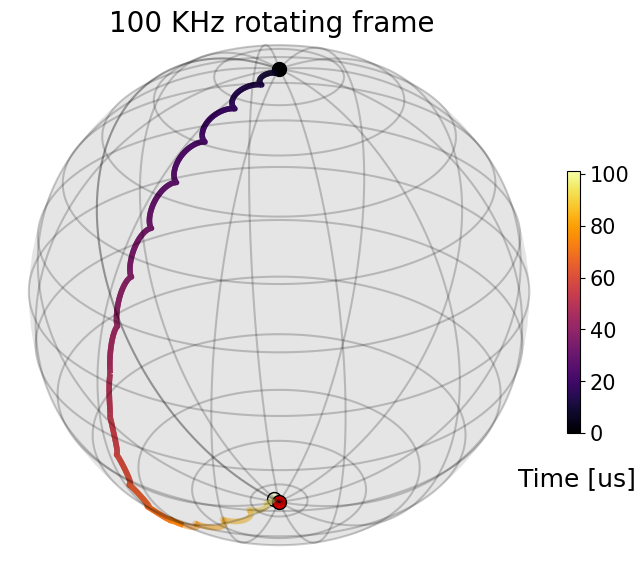

In [28]:
#rf magnetic field at the resonance condition for realistic fields
t_n = 2000  #total number of time points
dist = 10.  #centimeters
tf = dist/get_vg(4)
time,tau = get_mesh(t_n,0,tf)
freq = 100e3*1e-6  #rf frequency (Hz)

B0 = 2*np.pi*freq/abs(GAMMA)
amp = 2*np.pi/abs(GAMMA)/tf
rf_env = B_sol(time,10,90,5,1)
cf = tf/sc.integrate.trapezoid(rf_env,x=time)
print(f'Amplitude correction factor: {round(cf,2)}')

B_rf = get_3D(fz=np.full(t_n,B0),fx=rf_env*amp*cf*np.cos(2*np.pi*freq*time))
plot_f(B_rf,time,plot_parms=Bt_plot_parms,plots=(True,False,False,False))

start = get_so3_state(x=0,y=0,z=1)
states = do_run(start,B_rf,time,tau)
print(f'Final state: {np.round(states[-1,:],5)}')

plot_f(states,time,plot_parms=P_plot_parms,plots=(True,True,True,False))
plot_Bloch(states,title=f'{round(freq*1e3)} KHz lab frame',elev=30,azim=130,roll=0)

rotated = get_rot_frame(states,time,2*np.pi*freq)
plot_f(rotated,time,plot_parms=P_plot_parms,plots=(True,True,True,True))
plot_Bloch(rotated,title=f'{round(freq*1e3)} KHz rotating frame',elev=30,azim=130,roll=0)

## RF flipper simulations
***

This section specializes in performing calculations with the IU radio-frequency neutron spin flipper. We assume that the static field is purely in the vertical direction and the rf field is the longitudinal direction.

### RF flipper model definitions and global parameters

In [ ]:
LAM = LAMS['CG4B']
t_n = 2000  #total number of time points
LENGTH = 8.  #distance between HTS films
tf = LENGTH/get_vg(LAM)
time,tau = get_mesh(t_n,0,tf)

#example magnetic field models for the rf flippers
B0_ideal = get_3D(fz=np.full(t_n,B0))
B0_sol = get_3D(fz=np.full(t_n,B0))
B0_noisy = get_3D(fz=np.full(t_n,B0))

Brf_ideal = get_3D(fz=np.full(t_n,B0))
Brf_gauss = get_3D(fz=np.full(t_n,B0))
Brf_smtp = get_3D(fz=np.full(t_n,B0))
Brf_step = get_3D(fz=np.full(t_n,B0))
Brf_noisy = get_3D(fz=np.full(t_n,B0))

@time_run
def tune_flipper(tune_parm,sim_args,sim_kwargs,plot_tune=True):
    '''Evaluates the efficieny of the flipper while varying a given model parameter.
    tune_parm is a tuple of the name (string) of the parameter scanned and the values.'''
    parm,vals = tune_parm
    scan = [do_simulation(*sim_args,**sim_kwargs)]
    if plot_tune:
        print(scan.shape)
        #plt.plot(scan[:,...,-1,0])
    return scan

start = get_so3_state(x=0,y=0,z=1)
run_parms
_ = tune_flipper((start,run_parms,fields,mesh_parms))

### Model of IU RF flipper using Magnet data

In [35]:
DEFAULT_PATH = 'C:\\Users\\samck\\Documents\\GitHub\\QBS\\'

def data_reader(fname,path=DEFAULT_PATH,header=2):
    '''Loads magnetic field data into array.'''
    with open(path+fname) as f:
        pass
    return 0

### Simulations scans

##### Gaussian rf profile

## Old code
***

In [ ]:
def do_model_scan(model_seq1, model_seq2, parm, plots_scans=False,plot_tune=True,return_new=True):
    """Performs a scan of a model. Can compare tuning curves with a
    second model sequence. parm is a tupule of 2 strings that keeps track of the 
    tuning parameter and the scan of the parameter itself. Can also return new
    best flip parameter."""
    pols1 = [[] for m in model_seq1]
    pols2 = [[] for m in model_seq2]
    for indx,m in enumerate(model_seq1):
        Bt = get_rf_flipper(m,T,TAU,Z,DELTA,VG,plot=False)
        pols1[indx] = do_sim(yp,Bt,T,TAU,plot_bt=False,\
                         plot_pol=plots_scans,plot_Pi=(True,True,True,False))
    if len(model_seq2)!=0:
        for indx,m in enumerate(model_seq2):
            Bt = get_rf_flipper(m,T,TAU,Z,DELTA,VG,plot=False)
            pols2[indx] = do_sim(yp,Bt,T,TAU,plot_bt=False,\
                              plot_pol=plots_scans,plot_Pi=(True,True,True,False))
    pols1,pols2 = np.array(pols1),np.array(pols2)
    if plot_tune:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Tuning curve')
        plt.xlabel(f'{parm[0]} ({parm[1]})')
        plt.ylabel('Exit pol.')
        plt.plot(parm[2], pols1[:,-1,1],'o-',ms=6,linewidth=6)
        if len(model_seq2)!=0:
            plt.plot(parm[2], pols2[:,-1,1],'o-',ms=6,linewidth=6)
        plt.grid()
        plt.show()
        
    new_parm1 = parm[2][np.argmin(pols1[:,-1,1])]
    new_parm2 = parm[2][np.argmin(pols2[:,-1,1])]
    print(f'SEQ1: Min pol of {np.min(pols1[:,-1,1])} at {parm[0]+" "+parm[1]} {round(new_parm1,5)}.')
    print(f'SEQ2: Min pol of {np.min(pols2[:,-1,1])} at {parm[0]+" "+parm[1]} {round(new_parm2,5)}.')
    if return_new: return new_parm1, new_parm2, pols1, pols2
    else: return pols1, pols2

def model_compare(model_1,model_2,plot_b=False):
    """Compares flipping efficiencies between two input models."""
    Bt1 = get_rf_flipper(model_1,T,TAU,Z,DELTA,VG)
    Bt2 = get_rf_flipper(model_2,T,TAU,Z,DELTA,VG)

    pols1 = do_sim(yp,Bt1,T,TAU,plot_bt=plot_b,plot_pol=True,\
                   plot_Bi=(False,True,True,False),plot_Pi=(True,True,True,False))
    pols2 = do_sim(yp,Bt2,T,TAU,plot_bt=plot_b,plot_pol=True,\
                   plot_Bi=(False,True,True,False),plot_Pi=(True,True,True,False))

    print(f'Model 1: Minimum pol: {round(np.min(pols1[:,1]),5)}')
    tmin1 = np.argmin(pols1[:,1])
    print(f'Model 1: Minimum pol at t={round(T[tmin1],5)} \n')
    
    print(f'Model 2: Minimum pol: {round(np.min(pols2[:,1]),5)}')
    tmin2 = np.argmin(pols2[:,1])
    print(f'Model 2: Minimum pol at t={round(T[tmin2],5)} \n')

    print('Model 1: Final pol: ', round(pols1[-1,1],5))
    print('Model 2: Final pol: ', round(pols2[-1,1],5))
    return pols1,pols2

def get_envelope(pols1,pols2,s=0,e=-1,plot=True):
    """Returns oscillation envelopes."""
    env_x1,env_z1 = np.abs(hilbert(pols1[:,0])),np.abs(hilbert(pols1[:,2]))
    env_x2,env_z2 = np.abs(hilbert(pols2[:,0])),np.abs(hilbert(pols2[:,2]))

    if plot: #compares polarizations
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. envelope')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        plt.plot(T[s:e],env_x1[s:e],'--', color='C0', linewidth=4)
        plt.plot(T[s:e],env_x2[s:e],'-', color='C0', linewidth=4, label='Px')
        plt.plot(T[s:e],pols1[s:e,1],'--', color='C1', linewidth=4)
        plt.plot(T[s:e],pols2[s:e,1],'-', color='C1', linewidth=4, label='Py')
        plt.plot(T[s:e],-env_z1[s:e],'--', color='C2', linewidth=4)
        plt.plot(T[s:e],-env_z2[s:e],'-', color='C2', linewidth=4, label='-Pz')
        plt.grid()
        plt.legend()
        plt.show()     
    return env_x1,env_z1,env_x2,env_z2

def do_stability_check(pols1,pols2,s=-1000,e=-1,plot_exit=True):
    """Plots polarization near the exit of the flipper (or near the minimum
    polarization). Returns nothing."""
    if plot_exit:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. near flipper exit')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        plt.plot(T[s:e],pols1[s:e,0], '--', color='C0', linewidth=4)
        plt.plot(T[s:e],pols2[s:e,0], color='C0', linewidth=4, label='Px')
        plt.plot(T[s:e],np.ones(abs(s-e))+pols1[s:e,1], '--', color='C1', linewidth=4)
        plt.plot(T[s:e],np.ones(abs(s-e))+pols2[s:e,1], color='C1', linewidth=4, label='1+Py')
        plt.plot(T[s:e],pols1[s:e,2], '--', color='C2', linewidth=4)
        plt.plot(T[s:e],pols2[s:e,2], color='C2', linewidth=4, label='Pz')
        plt.grid()
        plt.legend()
        plt.show()
    else: #minimum is exit for perfect flipper
        tmin1,pol_min1 = np.argmin(pols1[:,1]), np.min(pols1[:,1])
        tmin2,pol_min2 = np.argmin(pols2[:,1]), np.min(pols2[:,1])
        delta = int(abs(s-e)/2) #symmetric around min
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. near minimum (1)')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        plt.plot(T[tmin1-delta:tmin1+delta],pols1[tmin1-delta:tmin1+delta,0], linewidth=5, label='Px')
        plt.plot(T[tmin1-delta:tmin1+delta],\
                 1+pols1[tmin1-delta:tmin1+delta,1], linewidth=5, label='1+Py')
        plt.plot(T[tmin1-delta:tmin1+delta],pols1[tmin1-delta:tmin1+delta,2], linewidth=5, label='Pz')
        plt.grid()
        plt.legend()
        plt.show()
        print(f'Minimum of {round(pol_min1,5)} at t={round(T[tmin1],3)} \n')
        
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. near minimum (2)')
        plt.xlabel('Time (us)')
        plt.ylabel('Pol.')
        plt.plot(T[tmin2-delta:tmin2+delta],pols2[tmin2-delta:tmin2+delta,0], linewidth=5, label='Px')
        plt.plot(T[tmin2-delta:tmin2+delta],\
                 1+pols2[tmin2-delta:tmin2+delta,1], linewidth=5, label='1+Py')
        plt.plot(T[tmin2-delta:tmin2+delta],pols2[tmin2-delta:tmin2+delta,2], linewidth=5, label='Pz')
        plt.grid()
        plt.legend()
        plt.show()
        print(f'Minimum of {round(pol_min2,5)} at t={round(T[tmin2],3)} \n')

### Modeling the rf amplitude with lab data:

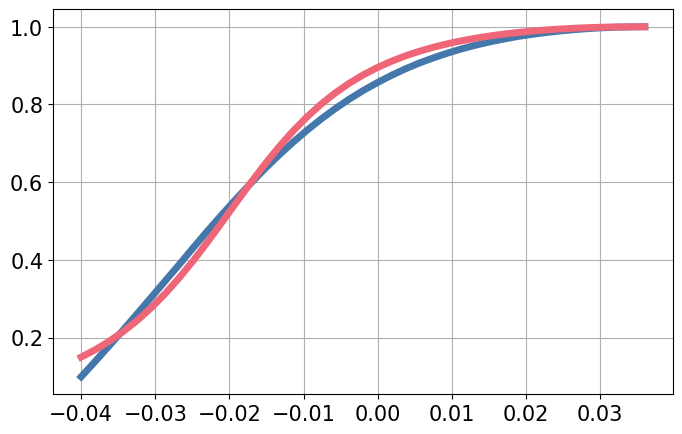

In [34]:
def fs(z,R,start,end):
    temp = ((z-start)/np.sqrt((z-start)**2 + R**2) - (z-end)/np.sqrt((z-end)**2 + R**2))
    return 1/np.max(temp)*temp

real_rf = [12.32567932,12.32086105,12.31193595,12.29454577,12.26900429,12.23531153,12.19346747,12.14347213,12.08532549,\
           12.01902756,11.93720972,11.84662874,11.74309357,11.62420775,11.48997126,11.34038411,11.1754463,10.98867451,\
           10.77982848,10.54901546,10.2988534,10.02202053,9.71851683,9.388342316,9.031496982,8.64798083,8.237793859,\
           7.806084708,7.342475923,6.864145888,6.371094603,5.863322069,5.340828286,4.803613252,4.281318755,3.754428023,\
           3.232455925,2.716295675,2.209035134,1.710843131,1.220842601]
real_rf = real_rf/np.max(real_rf)
pos = np.linspace(.036,-.04,41)

fig = plt.figure(figsize=(8,5))
plt.plot(pos,real_rf,linewidth=5)
plt.plot(pos,fs(pos,0.02,-.02,.09),linewidth=5)
plt.grid()
plt.show()

In [ ]:
x,a0,a1,a2,a3,x1,x2 = sym.symbols('x,a_0,a_1,a_2,a_3,x_1,x_2', real=True)

def s(x,a0,a1,a2,a3):
    return a3*x**3 + a2*x**2 + a1*x + a0
def sp(x,a1,a2,a3):
    return 3*a3*x**2 + 2*a2*x + a1

eq1 = sym.Eq(s(x1,a0,a1,a2,a3),0)
eq2 = sym.Eq(s(x2,a0,a1,a2,a3),1)
eq3 = sym.Eq(sp(x1,a1,a2,a3),0)
eq4 = sym.Eq(sp(x2,a1,a2,a3),0)

display(eq1)
display(eq2)
display(eq3)
display(eq4)

sol = sym.solve((eq1,eq2,eq3,eq4),(a0,a1,a2,a3))
display(sol)

### Miscellaneous calculations

In [ ]:
def doppler(freq, v): #checking the strength of the Doppler effect
    new_freq = (1+v/2.99e8)*freq
    return new_freq
print(f'New frequency: {round(doppler(4e6,989),1)}')

In [ ]:
def irr(freq,n,I,a): #checking the power radiated, from Zangwill E&M
    return 1/2*4*np.pi*1e-7*(n*I*np.pi*a*sc.special.jv(1,freq*a/3e8))**2*freq

print(f'Power irradiated (Watts): {round(irr(2*np.pi*4e6,1e3,1,.02),3)}')